***
#  Part 1: Data Retrieval
***

# Gather relevant data 

## Webscrape demographic data 

Import Relevant packages

In [1]:
import pandas as pd
import numpy as np
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from pandasql import sqldf
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans

Checks to confirm page exists

In [2]:
url = 'https://www.zip-codes.com{}'
columbus_branch ='/city/oh-columbus.asp'
# reinforces integrity of the data collection
accessed = False
while accessed == False:
    try:
        response = requests.get(url.format(columbus_branch))
        print(response)
        accessed = True
    except:
        accesssed = False

<Response [200]>


Gathers relevant data on the page

In [3]:
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    tbl = soup.table.tr.find_all('td')[1].find_all('table')[1]
    print(tbl)

<table border="0" cellpadding="0" cellspacing="0" class="statTable" id="tblZIP" width="99%">
<tr><td class="label"><strong>ZIP Code</strong></td><td><strong>Type</strong></td><td><strong>County</strong></td><td><strong>Population</strong></td><td><strong>Area Code(s)</strong></td></tr>
<tr><td><a href="/zip-code/43081/zip-code-43081.asp" style="text-decoration:underline;" title="ZIP Code 43081, WESTERVILLE, OH">ZIP Code 43081</a></td><td>Standard</td><td><a href="/county/oh-franklin.asp">Franklin</a></td><td>55,991</td><td><a href="/area-code/area-code-614.asp" title="Area Code 614">614</a></td></tr><tr><td><a href="/zip-code/43085/zip-code-43085.asp" style="text-decoration:underline;" title="ZIP Code 43085, COLUMBUS, OH">ZIP Code 43085</a></td><td>Standard</td><td><a href="/county/oh-franklin.asp">Franklin</a></td><td>23,258</td><td><a href="/area-code/area-code-614.asp" title="Area Code 614">614</a> / <a href="/area-code/area-code-380.asp" title="Area Code 380">380</a> / <a href="/ar

function to help web scrape zip code information

In [4]:
# utilize when using the table the [0-4] table 
# BeautifulSoup(response.text, 'html.parser').table.tr.find_all('td')[1].find_all('table')
def zip_info(response):
    page = BeautifulSoup(response.text, 'html.parser').find_all("table", class_="statTable")
    #print(page)
    dict = {}
    for table in page:
        for row in table.find_all('tr'):
            dict[row.find_all('td')[0].string] = row.find_all('td')[1].string        
    return dict

Parses through and gathers data

In [5]:
i=0
zip_info_df = pd.DataFrame()
zip_url = '/zip-code/{}/zip-code-{}.asp'
for row in tbl.find_all('tr'):
    #checks for header
    if row.find_all('td')[0].string != 'ZIP Code':
        if row.find_all('td')[1].string == 'Standard':
            zip_code = row.find_all('td')[0].string.strip(" ZIPCode")
            #coded just to make sure that we can access the website
            accessed = False
            while accessed == False:
                try:
                    zip_response = requests.get(url.format(zip_url.format(zip_code,zip_code)))
                    accessed = True
                    i+=1
                    zip_dict = zip_info(zip_response)
                    zip_info_df = zip_info_df.append(zip_dict, ignore_index=True)
                except:
                    accessed = False
print(zip_info_df)
# reads in all zip code responses

   # Business Mailboxes: # Residential Mailboxes: # of Employees:  \
0                  1,375                   27,973          28,811   
1                  1,108                   10,609          18,013   
2                    799                   17,791           9,974   
3                    398                   10,555           5,133   
4                    214                    4,367           1,198   
5                    842                   17,857           9,930   
6                    462                    5,973          15,488   
7                    489                   11,140           6,408   
8                  1,162                   19,154          18,937   
9                    530                   12,038           6,965   
10                   266                      325          10,769   
11                   448                    9,015           3,287   
12                 1,023                   13,257          19,020   
13                 1,287          

In [6]:
zip_info_df.columns
zip_info_df = zip_info_df.infer_objects()

## Location data for Hospitals and Pharmacies

Get relevant packages

In [7]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


Credentials for foursquare_API

In [8]:
# @hidden_cell
CLIENT_ID = '3PRTA5P0AY2A12Z51Z1UHCZH124K5AYLU4PGQHQ0BMCV5FWD' # your Foursquare ID
CLIENT_SECRET = 'JOQYBGLRRR0QNOYE43VOVALU1DFGK4TGSR23SS3J53X2G4JW' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 60
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3PRTA5P0AY2A12Z51Z1UHCZH124K5AYLU4PGQHQ0BMCV5FWD
CLIENT_SECRET:JOQYBGLRRR0QNOYE43VOVALU1DFGK4TGSR23SS3J53X2G4JW


Information for using foursquare API 

In [9]:
zip_info_df.columns

Index(['# Business Mailboxes:', '# Residential Mailboxes:', '# of Employees:',
       '113th Congressional District:', '113th Congressional Land Area:',
       '1st Quarter Payroll:', '2010 Population:', '65+:',
       'American Indian Population:', 'Annual Payroll:', 'Area Code:',
       'Asian Population:', 'Average House Value:',
       'Avg. Income Per Household:', 'Black Population:',
       'CBSA Division Name:', 'CBSA Division Population:', 'CBSA Division:',
       'CBSA Name:', 'CBSA Population:', 'CBSA Type:', 'CBSA:', 'Children:',
       'City Alias(es):', 'City State Key:', 'City Type:', 'City:',
       'Classification:', 'Counties:', 'County FIPS:', 'Current Population:',
       'Disabled Workers:', 'Division:', 'Elevation:', 'Female Median Age:',
       'Female Population:', 'Hawaiian Population:', 'Hispanic Population:',
       'Households per ZIP Code:', 'Intro Date:', 'Land Area:', 'Latitude:',
       'Longitude:', 'MSA Name:', 'MSA:', 'Male Median Age:',
       'Male P

In [10]:
CAT_IDs = {'Hospital':'4bf58dd8d48988d196941735', 'Pharmacy': '4bf58dd8d48988d10f951735'}
geo_coords = zip_info_df[['Latitude:','Longitude:']]
radius = 10000 #about 6.2 miles

Create parameters that are not hidden

In [11]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&categoryId={}&v={}&radius={}&limit={}'
url

'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&categoryId={}&v={}&radius={}&limit={}'

Grabs data for all hospitals and pharmacies

In [12]:
i=0
# Hospital and Pharmacy Data Frame
hp_df = pd.DataFrame()
while i<len(geo_coords): 
    lat = geo_coords.iloc[i]['Latitude:']
    long = geo_coords.iloc[i]['Longitude:']
    #hospitals
    temp_url = url.format(CLIENT_ID, CLIENT_SECRET, lat, long, CAT_IDs['Hospital'], VERSION, radius, LIMIT)
    results = requests.get(temp_url).json()
    hps = results['response']['venues']
    hp_df=hp_df.append(json_normalize(hps), ignore_index=True)
    #pharmacies
    temp_url = url.format(CLIENT_ID, CLIENT_SECRET, lat, long, CAT_IDs['Pharmacy'], VERSION, radius, LIMIT)
    results = requests.get(temp_url).json()
    hps = results['response']['venues']
    hp_df=hp_df.append(json_normalize(hps), ignore_index=True)
    i+=1
hp_df

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.crossStreet,location.neighborhood
0,4e806be17ee6677f0a2549a7,Child Development and Autism Centers,"[{'id': '4bf58dd8d48988d177941735', 'name': 'D...",v-1609951953,False,187 W Schrock Rd,40.109578,-82.931797,"[{'label': 'display', 'lat': 40.10957847827210...",2894,43081,US,Westerville,OH,United States,"[187 W Schrock Rd, Westerville, OH 43081, Unit...",NaN,NaN,NaN
1,550875f2498ed14f1962062f,Ohio State Outpatient Rehabilitation Gahanna YMCA,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,551 Ymca Pl,40.048370,-82.857063,"[{'label': 'display', 'lat': 40.04837036132812...",7311,43230,US,Gahanna,OH,United States,"[551 Ymca Pl, Gahanna, OH 43230, United States]",122931242,NaN,NaN
2,501d17b8e4b09fbdec1c12c9,H12B HEM/ONC At NCH,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,NaN,40.110148,-83.036035,"[{'label': 'display', 'lat': 40.11014760015202...",11751,43223,US,Columbus,OH,United States,"[Columbus, OH 43223, United States]",NaN,NaN,NaN
3,4b23ca02f964a520bf5924e3,Animal Hospital of Polaris,"[{'id': '4d954af4a243a5684765b473', 'name': 'V...",v-1609951953,False,8928 S Old State Rd,40.152349,-82.997784,"[{'label': 'display', 'lat': 40.15234859798208...",9926,43035,US,Lewis Center,OH,United States,[8928 S Old State Rd (Old State Road & Powell ...,35576025,Old State Road & Powell Road,NaN
4,4dd2dfe6ae60da0ebed12eec,Mt Carmel New Albany Surgical Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,7333 Smiths Mill Rd,40.086201,-82.789909,"[{'label': 'display', 'lat': 40.08620050813063...",9475,43054,US,New Albany,OH,United States,"[7333 Smiths Mill Rd, New Albany, OH 43054, Un...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2873,4d2c7a8c342d6dcb7ecb1fcb,Take Care Clinic,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1609951981,False,2150 E Dublin Granville Rd,40.087143,-82.959427,"[{'label': 'display', 'lat': 40.08714294433594...",6785,43229,US,Columbus,OH,United States,"[2150 E Dublin Granville Rd, Columbus, OH 4322...",NaN,NaN,NaN
2874,4d28cdb46e27a143bd0f1e24,Complete nutrition,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1609951981,False,7541 Sawmill Rd,40.120197,-83.091836,"[{'label': 'display', 'lat': 40.12019666683196...",9942,43016,US,Columbus,OH,United States,"[7541 Sawmill Rd, Columbus, OH 43016, United S...",NaN,NaN,NaN
2875,5163a42de4b095f6f027b6cc,Estra's Vitamin Shoppe,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1609951981,False,NaN,40.113375,-83.068552,"[{'label': 'display', 'lat': 40.11337511494923...",8367,NaN,US,Columbus,OH,United States,"[Columbus, OH, United States]",NaN,NaN,NaN
2876,500e2b02e4b0f585cbfbf28e,Heartlight Pharmacy,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1609951981,False,NaN,40.109854,-82.998364,"[{'label': 'display', 'lat': 40.10985424185838...",4319,43085,US,Columbus,OH,United States,"[Columbus, OH 43085, United States]",NaN,NaN,NaN


Filters to get unique Pharmacy and Hospital Locations

In [13]:
hp_df=hp_df.drop_duplicates(['id'])
hp_df

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.crossStreet,location.neighborhood
0,4e806be17ee6677f0a2549a7,Child Development and Autism Centers,"[{'id': '4bf58dd8d48988d177941735', 'name': 'D...",v-1609951953,False,187 W Schrock Rd,40.109578,-82.931797,"[{'label': 'display', 'lat': 40.10957847827210...",2894,43081,US,Westerville,OH,United States,"[187 W Schrock Rd, Westerville, OH 43081, Unit...",NaN,NaN,NaN
1,550875f2498ed14f1962062f,Ohio State Outpatient Rehabilitation Gahanna YMCA,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,551 Ymca Pl,40.048370,-82.857063,"[{'label': 'display', 'lat': 40.04837036132812...",7311,43230,US,Gahanna,OH,United States,"[551 Ymca Pl, Gahanna, OH 43230, United States]",122931242,NaN,NaN
2,501d17b8e4b09fbdec1c12c9,H12B HEM/ONC At NCH,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,NaN,40.110148,-83.036035,"[{'label': 'display', 'lat': 40.11014760015202...",11751,43223,US,Columbus,OH,United States,"[Columbus, OH 43223, United States]",NaN,NaN,NaN
3,4b23ca02f964a520bf5924e3,Animal Hospital of Polaris,"[{'id': '4d954af4a243a5684765b473', 'name': 'V...",v-1609951953,False,8928 S Old State Rd,40.152349,-82.997784,"[{'label': 'display', 'lat': 40.15234859798208...",9926,43035,US,Lewis Center,OH,United States,[8928 S Old State Rd (Old State Road & Powell ...,35576025,Old State Road & Powell Road,NaN
4,4dd2dfe6ae60da0ebed12eec,Mt Carmel New Albany Surgical Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,7333 Smiths Mill Rd,40.086201,-82.789909,"[{'label': 'display', 'lat': 40.08620050813063...",9475,43054,US,New Albany,OH,United States,"[7333 Smiths Mill Rd, New Albany, OH 43054, Un...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2863,589a0a369398ab160bd6a16e,Linworths Pharmacy,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1609951981,False,2245 W Dublin Granville Rd Ste 103,40.089636,-83.050087,"[{'label': 'display', 'lat': 40.08963617971150...",8660,43085,US,Worthington,OH,United States,"[2245 W Dublin Granville Rd Ste 103, Worthingt...",NaN,NaN,NaN
2864,547cc459498e5ae4c4c9edb2,Giant Eagle Supermarket,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1609951981,False,4000 West Powell Road,40.160699,-83.093700,"[{'label': 'display', 'lat': 40.1606991, 'lng'...",9810,43065,US,Powell,OH,United States,"[4000 West Powell Road, Powell, OH 43065, Unit...",NaN,NaN,NaN
2872,5104adbbe4b0ed508b8a2b5e,Campari Office,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1609951981,False,NaN,40.178708,-83.085247,"[{'label': 'display', 'lat': 40.178708, 'lng':...",9663,43065,US,Powell,OH,United States,"[Powell, OH 43065, United States]",NaN,NaN,NaN
2874,4d28cdb46e27a143bd0f1e24,Complete nutrition,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",v-1609951981,False,7541 Sawmill Rd,40.120197,-83.091836,"[{'label': 'display', 'lat': 40.12019666683196...",9942,43016,US,Columbus,OH,United States,"[7541 Sawmill Rd, Columbus, OH 43016, United S...",NaN,NaN,NaN


## COVID-19 Testing Locations

Install package

In [14]:
import PyPDF2
# source of pdf scraping https://www.youtube.com/watch?v=UmPe07a3bWs

Scrapes pdf itself

In [15]:
import io

import requests
from PyPDF2 import PdfFileReader

url = 'https://www.columbus.gov/uploadedFiles/Columbus/Departments/Public_Health/All_Programs/Emergency_Preparedness/Coronavirus/LocalTesting_FQHCs_7.16.2020.pdf'

r = requests.get(url)
f = io.BytesIO(r.content)

reader = PdfFileReader(f)
contents = reader.getPage(0).extractText().split('\n')
print(contents)

['COVID-19 Community Testing', 'No one will be turned away for inability to pay. Questions? Call Columbus Public Health at 614-645-1519.', '˜˚˛˝˙ˆˇ˘ˆ', '˜', '˜', 'Information compiled by ', 'Columbus Public Health; ', 'updated 10/6/2020', 'Columbus Public Health', ' (testing provided ', 'by Mount Carmel, OhioHealth and The Ohio ', 'State University Wexner Medical Center)', '614-645-1519', 'www.columbus.gov/coronavirus', '1. Ohio Expo Center & State Fair Celeste Center ', '717 E. 17th Ave., Columbus', 'Mon.-Fri. Œ 9 a.m.-4 p.m.', 'Heart of Ohio Family Health ', '614-235-5555', 'https://heartofohiofamilyhealth.org', '2. Capital Park Family Health Center ', '2365 Innis Rd., Columbus', 'Mon., Tue., Wed., Fri. Œ 8 a.m.-5 p.m.', 'Thu., Œ 8 a.m.-7:30 p.m.', '3. Whitehall Family Health Center ', '882 S. Hamilton Rd., Whitehall', 'Mon., Wed., Thu., Fri. Œ 8 a.m.-5 p.m.', 'Tue. Œ 8 a.m.-7:30 p.m.', 'Lower Lights Christian Health Center ', '614-274-1455', 'https://llchc.org/covid19', '4. Lower Li

Filters to grab address

In [16]:
import re

address_extract ='\d+[ ](?:[A-Za-z0-9.-]+[ ]?)+(?:Avenue|Lane|Road|Boulevard|Drive|Street|Ave|Dr|Rd|Blvd|Ln|St)\.?'
p = re.compile(address_extract)
testingLocations = [ content for content in contents if p.match(content)]
p2 = re.compile('\d+\.')
covid_test_providers = [ content for content in contents if p2.match(content)]
testingLocations = testingLocations+[re.sub("\d+\.","",test) for test in covid_test_providers if re.search(address_extract,test)]
print(testingLocations)

['717 E. 17th Ave., Columbus', '2365 Innis Rd., Columbus', '882 S. Hamilton Rd., Whitehall', '777 W. State St., Columbus', '2300 W. Broad St., Columbus', '1905 Parsons Ave., Columbus', '3433 Agler Rd., Columbus', '1500 E. 17th Ave., Columbus', '750 E. Long St., Columbus', ' 86 N. Front St., Columbus']


# Get Cases by ZIP

## COVID-19 Numbers

In [17]:
zip_cases_df =  pd.read_csv("https://coronavirus.ohio.gov/static/dashboards/COVIDSummaryDataZIP.csv")
zip_cases_df.head()

,Zip Code,Population,Case Count - Cumulative,Case Count - Last 30 Days,Case Count - Last 14 Days,Case Count Per 100K - Cumulative,Case Count Per 100K - Last 30 Days,Case Count Per 100K - Last 14 Days
0,43001,"2,810",154,34,11.0,"5,480.40","1,210.00",391.5
1,43002,"3,744",NaN,NaN,NaN,NaN,NaN,NaN
2,43003,"3,005",145,58,28.0,"4,825.30","1,930.10",931.8
3,43004,"26,139","2,353",591,250.0,"9,001.90","2,261.00",956.4
4,43005,201,10,NaN,NaN,"4,975.10",NaN,NaN


***
#  Part 2: Modifying of data
The Dataframes are:
- zip_cases_df: Cases in Zip codes 
- testingLocations: Locations of current testing sites
- hp_df: Hospital and Pharmacy Location
- zip_info_df: Demographic Information by Zip code

***

## Modify zip_info_df:

In [18]:
zip_info_df.columns

Index(['# Business Mailboxes:', '# Residential Mailboxes:', '# of Employees:',
       '113th Congressional District:', '113th Congressional Land Area:',
       '1st Quarter Payroll:', '2010 Population:', '65+:',
       'American Indian Population:', 'Annual Payroll:', 'Area Code:',
       'Asian Population:', 'Average House Value:',
       'Avg. Income Per Household:', 'Black Population:',
       'CBSA Division Name:', 'CBSA Division Population:', 'CBSA Division:',
       'CBSA Name:', 'CBSA Population:', 'CBSA Type:', 'CBSA:', 'Children:',
       'City Alias(es):', 'City State Key:', 'City Type:', 'City:',
       'Classification:', 'Counties:', 'County FIPS:', 'Current Population:',
       'Disabled Workers:', 'Division:', 'Elevation:', 'Female Median Age:',
       'Female Population:', 'Hawaiian Population:', 'Hispanic Population:',
       'Households per ZIP Code:', 'Intro Date:', 'Land Area:', 'Latitude:',
       'Longitude:', 'MSA Name:', 'MSA:', 'Male Median Age:',
       'Male P

## Drop Columns

Note: Top 17 guessed chosen for simplicity sake of project
In addition to Zip Code, Latitude,Longitude, and Current Population

In [19]:
zip_info_df=zip_info_df[['Zip Code:','Latitude:','Longitude:','Elevation:','Current Population:','Households per ZIP Code:','Average House Value:','Avg. Income Per Household:','Persons Per Household:','White Population:','Median Age:','Male Population:','Female Population:','Black Population:','Hispanic Population:','Retired Workers:','Disabled Workers:','Spouses:','Children:', 'Number of Businesses:','# of Employees:']]

### Reasons for certain factors:
- Sex & Race: The number of cases of COVID-19 may be correlated with gender as some studies have already shown.
- Latitude: Never actually shown or prooven but it could be a factor to look into
- Spouses and Children: These people may approach the virus more differently than those who aren't in the category
- Number of Businesses: This may affect people's response to the virus based off of News occuring as far as the pandemic
- Type of workers: These workers may come predisposed to the virus or coming into contact with it


Look at head of data frame

In [20]:
zip_info_df.head()

,Zip Code:,Latitude:,Longitude:,Elevation:,Current Population:,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,White Population:,...,Male Population:,Female Population:,Black Population:,Hispanic Population:,Retired Workers:,Disabled Workers:,Spouses:,Children:,Number of Businesses:,# of Employees:
0,43081,40.106049,-82.898116,873 ft,"66,855","22,754","$197,800","$81,813",2.39,"47,805",...,"26,675","29,316","6,078","1,677","7,195",800,365,485,1318,"28,811"
1,43085,40.100474,-83.013908,905 ft,"25,037","9,768","$247,500","$83,524",2.36,"20,891",...,"11,025","12,233","1,377",822,"3,030",435,180,300,977,"18,013"
2,43201,39.995575,-82.999464,784 ft,"39,851","14,697","$240,700","$31,891",2.24,"27,369",...,"20,162","15,333","5,495","1,493",630,380,30,115,630,"9,974"
3,43202,40.020272,-83.017128,724 ft,"21,426","9,952","$208,300","$53,331",2.03,"17,151",...,"10,854","9,397","1,027",658,840,160,40,50,275,"5,133"
4,43203,39.971834,-82.966754,821 ft,"9,825","3,533","$89,400","$28,072",2.25,"1,160",...,"3,894","4,214","6,941",173,650,255,25,140,110,"1,198"


Filter out irrelevant symbols or words with regex

In [21]:
zip_info_df = zip_info_df.replace(',|\$|(s|ft)|(s|years)','',regex=True)
zip_info_df.head()

,Zip Code:,Latitude:,Longitude:,Elevation:,Current Population:,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,White Population:,...,Male Population:,Female Population:,Black Population:,Hispanic Population:,Retired Workers:,Disabled Workers:,Spouses:,Children:,Number of Businesses:,# of Employees:
0,43081,40.106049,-82.898116,873,66855,22754,197800,81813,2.39,47805,...,26675,29316,6078,1677,7195,800,365,485,1318,28811
1,43085,40.100474,-83.013908,905,25037,9768,247500,83524,2.36,20891,...,11025,12233,1377,822,3030,435,180,300,977,18013
2,43201,39.995575,-82.999464,784,39851,14697,240700,31891,2.24,27369,...,20162,15333,5495,1493,630,380,30,115,630,9974
3,43202,40.020272,-83.017128,724,21426,9952,208300,53331,2.03,17151,...,10854,9397,1027,658,840,160,40,50,275,5133
4,43203,39.971834,-82.966754,821,9825,3533,89400,28072,2.25,1160,...,3894,4214,6941,173,650,255,25,140,110,1198


Converts all columns to sometype of numeric value

In [22]:
for i in zip_info_df.columns:
    zip_info_df[i] = pd.to_numeric(zip_info_df[i])
zip_info_df.dtypes   

Zip Code:                       int64
Latitude:                     float64
Longitude:                    float64
Elevation:                      int64
Current Population:             int64
Households per ZIP Code:        int64
Average House Value:            int64
Avg. Income Per Household:      int64
Persons Per Household:        float64
White Population:               int64
Median Age:                   float64
Male Population:                int64
Female Population:              int64
Black Population:               int64
Hispanic Population:            int64
Retired Workers:                int64
Disabled Workers:               int64
Spouses:                        int64
Children:                       int64
Number of Businesses:           int64
# of Employees:                 int64
dtype: object

Renames columns without colons

In [23]:
zip_info_df = zip_info_df.rename(columns={str(i): str(i)[:-1] for i in zip_info_df.columns},errors='raise')
zip_info_df.dtypes  

Zip Code                       int64
Latitude                     float64
Longitude                    float64
Elevation                      int64
Current Population             int64
Households per ZIP Code        int64
Average House Value            int64
Avg. Income Per Household      int64
Persons Per Household        float64
White Population               int64
Median Age                   float64
Male Population                int64
Female Population              int64
Black Population               int64
Hispanic Population            int64
Retired Workers                int64
Disabled Workers               int64
Spouses                        int64
Children                       int64
Number of Businesses           int64
# of Employees                 int64
dtype: object

In [24]:
zip_info_df = zip_info_df.rename(columns={str(i): re.sub('\:|\.|\s', '', str(i)) for i in zip_info_df.columns},errors='raise')
zip_info_df = zip_info_df.astype({'ZipCode': 'object'})
zip_info_df.dtypes  

ZipCode                   object
Latitude                 float64
Longitude                float64
Elevation                  int64
CurrentPopulation          int64
HouseholdsperZIPCode       int64
AverageHouseValue          int64
AvgIncomePerHousehold      int64
PersonsPerHousehold      float64
WhitePopulation            int64
MedianAge                float64
MalePopulation             int64
FemalePopulation           int64
BlackPopulation            int64
HispanicPopulation         int64
RetiredWorkers             int64
DisabledWorkers            int64
Spouses                    int64
Children                   int64
NumberofBusinesses         int64
#ofEmployees               int64
dtype: object

## Modify hp_df:

In [25]:
hp_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.crossStreet,location.neighborhood
0,4e806be17ee6677f0a2549a7,Child Development and Autism Centers,"[{'id': '4bf58dd8d48988d177941735', 'name': 'D...",v-1609951953,False,187 W Schrock Rd,40.109578,-82.931797,"[{'label': 'display', 'lat': 40.10957847827210...",2894,43081,US,Westerville,OH,United States,"[187 W Schrock Rd, Westerville, OH 43081, Unit...",NaN,NaN,NaN
1,550875f2498ed14f1962062f,Ohio State Outpatient Rehabilitation Gahanna YMCA,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,551 Ymca Pl,40.048370,-82.857063,"[{'label': 'display', 'lat': 40.04837036132812...",7311,43230,US,Gahanna,OH,United States,"[551 Ymca Pl, Gahanna, OH 43230, United States]",122931242,NaN,NaN
2,501d17b8e4b09fbdec1c12c9,H12B HEM/ONC At NCH,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,NaN,40.110148,-83.036035,"[{'label': 'display', 'lat': 40.11014760015202...",11751,43223,US,Columbus,OH,United States,"[Columbus, OH 43223, United States]",NaN,NaN,NaN
3,4b23ca02f964a520bf5924e3,Animal Hospital of Polaris,"[{'id': '4d954af4a243a5684765b473', 'name': 'V...",v-1609951953,False,8928 S Old State Rd,40.152349,-82.997784,"[{'label': 'display', 'lat': 40.15234859798208...",9926,43035,US,Lewis Center,OH,United States,[8928 S Old State Rd (Old State Road & Powell ...,35576025,Old State Road & Powell Road,NaN
4,4dd2dfe6ae60da0ebed12eec,Mt Carmel New Albany Surgical Hospital,"[{'id': '4bf58dd8d48988d196941735', 'name': 'H...",v-1609951953,False,7333 Smiths Mill Rd,40.086201,-82.789909,"[{'label': 'display', 'lat': 40.08620050813063...",9475,43054,US,New Albany,OH,United States,"[7333 Smiths Mill Rd, New Albany, OH 43054, Un...",NaN,NaN,NaN


In [26]:
hp_df.dtypes

id                            object
name                          object
categories                    object
referralId                    object
hasPerk                         bool
location.address              object
location.lat                 float64
location.lng                 float64
location.labeledLatLngs       object
location.distance              int64
location.postalCode           object
location.cc                   object
location.city                 object
location.state                object
location.country              object
location.formattedAddress     object
venuePage.id                  object
location.crossStreet          object
location.neighborhood         object
dtype: object

In [27]:
testingLocations

['717 E. 17th Ave., Columbus',
 '2365 Innis Rd., Columbus',
 '882 S. Hamilton Rd., Whitehall',
 '777 W. State St., Columbus',
 '2300 W. Broad St., Columbus',
 '1905 Parsons Ave., Columbus',
 '3433 Agler Rd., Columbus',
 '1500 E. 17th Ave., Columbus',
 '750 E. Long St., Columbus',
 ' 86 N. Front St., Columbus']

Somethings not kept in mind are:
- Categories may not be large enough to test
- Someplaces may not exist
Repetitive Information is kept just for further information purposes.

In [28]:
hp_df=hp_df.drop(columns=['referralId','hasPerk','location.distance','venuePage.id','location.crossStreet','location.neighborhood','categories','location.formattedAddress','location.labeledLatLngs'])
hp_df.head()

,id,name,location.address,location.lat,location.lng,location.postalCode,location.cc,location.city,location.state,location.country
0,4e806be17ee6677f0a2549a7,Child Development and Autism Centers,187 W Schrock Rd,40.109578,-82.931797,43081,US,Westerville,OH,United States
1,550875f2498ed14f1962062f,Ohio State Outpatient Rehabilitation Gahanna YMCA,551 Ymca Pl,40.048370,-82.857063,43230,US,Gahanna,OH,United States
2,501d17b8e4b09fbdec1c12c9,H12B HEM/ONC At NCH,NaN,40.110148,-83.036035,43223,US,Columbus,OH,United States
3,4b23ca02f964a520bf5924e3,Animal Hospital of Polaris,8928 S Old State Rd,40.152349,-82.997784,43035,US,Lewis Center,OH,United States
4,4dd2dfe6ae60da0ebed12eec,Mt Carmel New Albany Surgical Hospital,7333 Smiths Mill Rd,40.086201,-82.789909,43054,US,New Albany,OH,United States


In [29]:
hp_df.dtypes

id                      object
name                    object
location.address        object
location.lat           float64
location.lng           float64
location.postalCode     object
location.cc             object
location.city           object
location.state          object
location.country        object
dtype: object

Rename columns

In [30]:
hp_df = hp_df.rename(columns={str(i): re.sub('(location.)', '', str(i)) for i in hp_df.columns},errors='raise')
hp_df.dtypes

id             object
name           object
address        object
lat           float64
lng           float64
postalCode     object
cc             object
city           object
state          object
country        object
dtype: object

## Modify zip_cases_df:

In [31]:
zip_cases_df.dtypes

Zip Code                               object
Population                             object
Case Count - Cumulative                object
Case Count - Last 30 Days              object
Case Count - Last 14 Days             float64
Case Count Per 100K - Cumulative       object
Case Count Per 100K - Last 30 Days     object
Case Count Per 100K - Last 14 Days     object
dtype: object

filters some data types

In [32]:
zip_cases_df = zip_cases_df.replace(',|\$|(s|ft)|(s|years)','',regex=True)
zip_cases_df.head()

,Zip Code,Population,Case Count - Cumulative,Case Count - Last 30 Days,Case Count - Last 14 Days,Case Count Per 100K - Cumulative,Case Count Per 100K - Last 30 Days,Case Count Per 100K - Last 14 Days
0,43001,2810,154,34,11.0,5480.40,1210.00,391.5
1,43002,3744,NaN,NaN,NaN,NaN,NaN,NaN
2,43003,3005,145,58,28.0,4825.30,1930.10,931.8
3,43004,26139,2353,591,250.0,9001.90,2261.00,956.4
4,43005,201,10,NaN,NaN,4975.10,NaN,NaN


convert to proper data types

In [33]:
for i in zip_cases_df.columns:
    zip_cases_df[i] = pd.to_numeric(zip_cases_df[i],errors='ignore')
zip_cases_df.dtypes   

Zip Code                               object
Population                            float64
Case Count - Cumulative               float64
Case Count - Last 30 Days             float64
Case Count - Last 14 Days             float64
Case Count Per 100K - Cumulative      float64
Case Count Per 100K - Last 30 Days    float64
Case Count Per 100K - Last 14 Days    float64
dtype: object

In [34]:
zip_cases_df = zip_cases_df.rename(columns={str(i): re.sub('\-|\s|(Last)|(Days)', '', str(i)) for i in zip_cases_df.columns},errors='raise')
zip_cases_df 
zip_cases_df.dtypes 

ZipCode                        object
Population                    float64
CaseCountCumulative           float64
CaseCount30                   float64
CaseCount14                   float64
CaseCountPer100KCumulative    float64
CaseCountPer100K30            float64
CaseCountPer100K14            float64
dtype: object

***
#  Part 3: Filtering and Adjusting Data
***

Columns

In [35]:
print(zip_cases_df.dtypes)
print(zip_info_df.dtypes)
print(hp_df.dtypes)

ZipCode                        object
Population                    float64
CaseCountCumulative           float64
CaseCount30                   float64
CaseCount14                   float64
CaseCountPer100KCumulative    float64
CaseCountPer100K30            float64
CaseCountPer100K14            float64
dtype: object
ZipCode                   object
Latitude                 float64
Longitude                float64
Elevation                  int64
CurrentPopulation          int64
HouseholdsperZIPCode       int64
AverageHouseValue          int64
AvgIncomePerHousehold      int64
PersonsPerHousehold      float64
WhitePopulation            int64
MedianAge                float64
MalePopulation             int64
FemalePopulation           int64
BlackPopulation            int64
HispanicPopulation         int64
RetiredWorkers             int64
DisabledWorkers            int64
Spouses                    int64
Children                   int64
NumberofBusinesses         int64
#ofEmployees          

sqldf("SELECT * FROM iris_df LIMIT 10;", locals())
- returns data frame
- allows for sql queries with name of data frames used

Filter the zip codes.

In [36]:
zip_cases_df=sqldf("SELECT * FROM zip_cases_df WHERE ZipCode IN (SELECT ZipCode FROM zip_info_df);")#zip_cases_df
hp_df = sqldf("SELECT * FROM hp_df WHERE postalCode IN (SELECT ZipCode FROM zip_info_df);") #hp_df

In [37]:
zip_info_df.head()

,ZipCode,Latitude,Longitude,Elevation,CurrentPopulation,HouseholdsperZIPCode,AverageHouseValue,AvgIncomePerHousehold,PersonsPerHousehold,WhitePopulation,...,MalePopulation,FemalePopulation,BlackPopulation,HispanicPopulation,RetiredWorkers,DisabledWorkers,Spouses,Children,NumberofBusinesses,#ofEmployees
0,43081,40.106049,-82.898116,873,66855,22754,197800,81813,2.39,47805,...,26675,29316,6078,1677,7195,800,365,485,1318,28811
1,43085,40.100474,-83.013908,905,25037,9768,247500,83524,2.36,20891,...,11025,12233,1377,822,3030,435,180,300,977,18013
2,43201,39.995575,-82.999464,784,39851,14697,240700,31891,2.24,27369,...,20162,15333,5495,1493,630,380,30,115,630,9974
3,43202,40.020272,-83.017128,724,21426,9952,208300,53331,2.03,17151,...,10854,9397,1027,658,840,160,40,50,275,5133
4,43203,39.971834,-82.966754,821,9825,3533,89400,28072,2.25,1160,...,3894,4214,6941,173,650,255,25,140,110,1198


Modify Populations of zip_info_df in proportions to match that of zip_cases_df. Reasons for assumptions for adjustments are:

- Populations change and it is reasonable to suggest that the zips do the same
- It has been 10 years and census data is inaccurate going from 2010 to 2020 so this change must be kept in account.

In [38]:
zipGrowth = []
for i in zip_info_df.columns:
    if i == 'CurrentPopulation':
        zipGrowth = zip_cases_df.Population/zip_info_df[i]
    if i not in ['ZipCode','Latitude','Longitude','Elevation','PersonsPerHousehold','MedianAge','HouseholdsperZIPCode','NumberofBusinesses','AvgIncomePerHousehold','AverageHouseValue']:
       zip_info_df[i] =  np.multiply(zip_info_df[i],zipGrowth)
       zip_info_df[i] = zip_info_df[i].apply(np.ceil)

In [39]:
zip_info_df.head()

,ZipCode,Latitude,Longitude,Elevation,CurrentPopulation,HouseholdsperZIPCode,AverageHouseValue,AvgIncomePerHousehold,PersonsPerHousehold,WhitePopulation,...,MalePopulation,FemalePopulation,BlackPopulation,HispanicPopulation,RetiredWorkers,DisabledWorkers,Spouses,Children,NumberofBusinesses,#ofEmployees
0,43081,40.106049,-82.898116,873,61572.0,22754,197800,81813,2.39,44028.0,...,24568.0,27000.0,5598.0,1545.0,6627.0,737.0,337.0,447.0,1318,26535.0
1,43085,40.100474,-83.013908,905,26216.0,9768,247500,83524,2.36,21875.0,...,11545.0,12810.0,1442.0,861.0,3173.0,456.0,189.0,315.0,977,18862.0
2,43201,39.995575,-82.999464,784,33455.0,14697,240700,31891,2.24,22977.0,...,16927.0,12873.0,4614.0,1254.0,529.0,320.0,26.0,97.0,630,8374.0
3,43202,40.020272,-83.017128,724,21141.0,9952,208300,53331,2.03,16923.0,...,10710.0,9273.0,1014.0,650.0,829.0,158.0,40.0,50.0,275,5065.0
4,43203,39.971834,-82.966754,821,8368.0,3533,89400,28072,2.25,988.0,...,3317.0,3590.0,5912.0,148.0,554.0,218.0,22.0,120.0,110,1021.0


***
#  Part 4: Data Exploration
***

Basic Statistics

<AxesSubplot:>

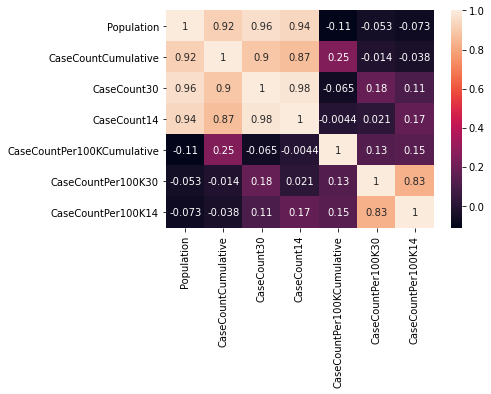

In [40]:
sns.heatmap(zip_cases_df.corr(),annot=True)

Mainly what I note in this heatmap is the correlations between each of the variables, mainly population correlates and case count correlate alot regardless of number of days. What is interesting to note is the same trenddoes not entirely occur in the proportions of the cummulative case count, in fact there is little to no correlation whatsoever.

In [41]:
zip_info_df.corrwith(zip_cases_df.CaseCountCumulative)

Latitude                 0.193028
Longitude                0.071202
Elevation                0.367176
CurrentPopulation        0.918107
HouseholdsperZIPCode     0.896425
AverageHouseValue        0.081071
AvgIncomePerHousehold    0.120264
PersonsPerHousehold     -0.051399
WhitePopulation          0.282209
MedianAge                0.069048
MalePopulation           0.328830
FemalePopulation         0.363465
BlackPopulation          0.424692
HispanicPopulation       0.637729
RetiredWorkers           0.719710
DisabledWorkers          0.554220
Spouses                  0.563900
Children                 0.618778
NumberofBusinesses       0.484639
#ofEmployees             0.046948
dtype: float64

In [42]:
zip_info_df.describe()

,Latitude,Longitude,Elevation,CurrentPopulation,HouseholdsperZIPCode,AverageHouseValue,AvgIncomePerHousehold,PersonsPerHousehold,WhitePopulation,MedianAge,MalePopulation,FemalePopulation,BlackPopulation,HispanicPopulation,RetiredWorkers,DisabledWorkers,Spouses,Children,NumberofBusinesses,#ofEmployees
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,39.999974,-82.984779,812.903226,29297.290323,11350.161290,155632.258065,50914.419355,2.326774,21752.193548,33.203226,15398.645161,15979.161290,7689.290323,1527.516129,2586.935484,703.774194,121.225806,325.161290,704.580645,21386.032258
std,0.071387,0.068954,60.900112,16144.182817,6167.689811,86838.199686,19653.729086,0.310874,24107.586098,4.893702,14866.561108,14427.445018,6795.446143,1531.611915,1784.473983,549.668670,96.750094,237.295188,525.658240,34712.632472
min,39.816625,-83.134338,714.000000,2440.000000,328.000000,0.000000,17179.000000,1.460000,988.000000,19.500000,979.000000,1071.000000,151.000000,67.000000,0.000000,0.000000,0.000000,0.000000,42.000000,1021.000000
25%,39.956474,-83.032139,765.500000,21245.500000,8049.500000,88500.000000,36986.500000,2.185000,7430.000000,31.450000,9752.000000,9760.500000,1431.000000,477.500000,864.500000,266.000000,36.500000,118.000000,327.000000,6859.000000
50%,39.995575,-82.979703,812.000000,26229.000000,10860.000000,136000.000000,46013.000000,2.330000,19382.000000,33.100000,12854.000000,12849.000000,5928.000000,1148.000000,2763.000000,465.000000,95.000000,294.000000,615.000000,11145.000000
75%,40.045262,-82.936419,853.000000,42568.000000,16441.500000,235150.000000,67385.000000,2.440000,27070.500000,36.500000,19465.000000,20550.500000,11574.000000,1701.500000,3695.500000,1111.500000,183.500000,481.000000,948.000000,20375.000000
max,40.146034,-82.863748,924.000000,61572.000000,22754.000000,335700.000000,93878.000000,3.310000,135605.000000,41.900000,86651.000000,82666.000000,23383.000000,6306.000000,6627.000000,2107.000000,337.000000,805.000000,2619.000000,193318.000000


In [43]:
zip_cases_df.describe()

,Population,CaseCountCumulative,CaseCount30,CaseCount14,CaseCountPer100KCumulative,CaseCountPer100K30,CaseCountPer100K14
count,31.000000,31.000000,31.000000,30.000000,31.000000,31.000000,30.000000
mean,29297.258065,1979.935484,435.838710,157.933333,6867.793548,1499.877419,534.893333
std,16144.132445,1148.176117,264.108954,98.094583,1816.991875,435.848981,155.228843
min,2440.000000,130.000000,23.000000,19.000000,4771.200000,183.600000,286.800000
25%,21245.500000,1308.500000,275.500000,101.750000,5715.450000,1305.200000,438.125000
50%,26229.000000,1714.000000,397.000000,136.000000,6292.800000,1467.200000,507.600000
75%,42568.000000,2759.000000,610.000000,204.500000,7519.400000,1620.550000,598.200000
max,61572.000000,4322.000000,961.000000,383.000000,11869.800000,2617.700000,1065.600000


<AxesSubplot:xlabel='ZipCode', ylabel='population'>

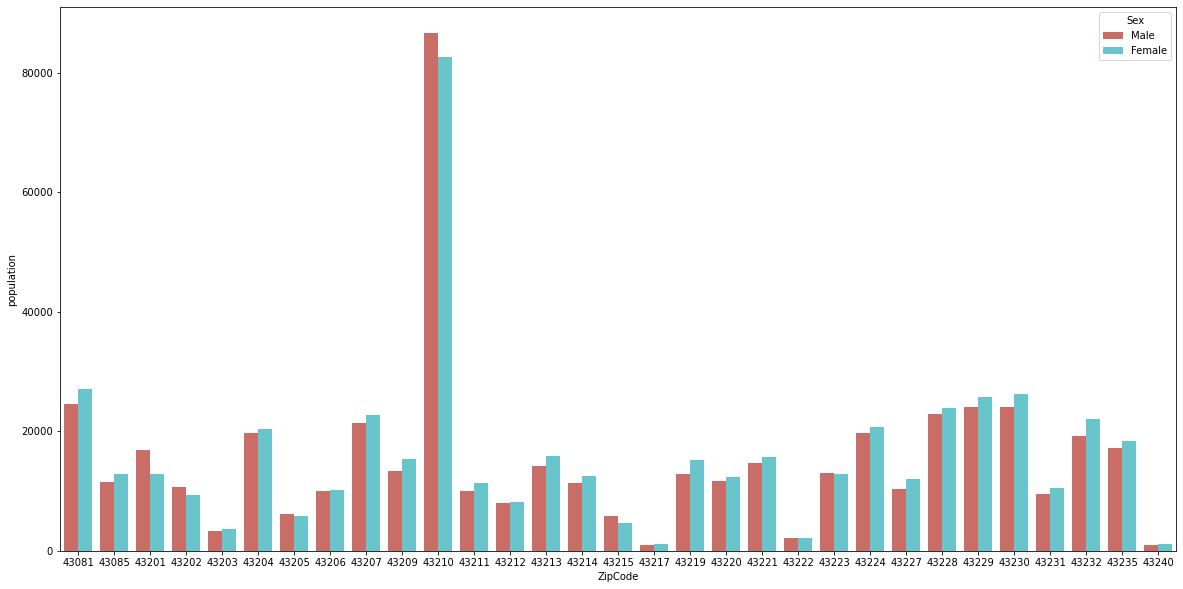

In [44]:
fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(x='ZipCode',y='population',hue='Sex',data=sqldf("select ZipCode, MalePopulation as population, 'Male' as Sex from zip_info_df union select ZipCode,FemalePopulation,'Female' from zip_info_df;"),palette='hls',ax= ax)


***
#  Part 5: Clustering Algorithms 
***

### Weight the observations

sql to combine dataframes

In [45]:
grand_zip_df = sqldf("SELECT zip_info_df.*, zip_cases_df.* from zip_info_df INNER JOIN zip_cases_df on zip_cases_df.ZipCode = zip_info_df.ZipCode;").drop(columns=['CurrentPopulation'])
population = grand_zip_df.Population
#grand_zip_df = grand_zip_df.drop(columns=['Population'])
grand_zip_df.head()

,ZipCode,Latitude,Longitude,Elevation,HouseholdsperZIPCode,AverageHouseValue,AvgIncomePerHousehold,PersonsPerHousehold,WhitePopulation,MedianAge,...,NumberofBusinesses,#ofEmployees,ZipCode,Population,CaseCountCumulative,CaseCount30,CaseCount14,CaseCountPer100KCumulative,CaseCountPer100K30,CaseCountPer100K14
0,43081,40.106049,-82.898116,873,22754,197800,81813,2.39,44028.0,35.7,...,1318,26535.0,43081,61572.0,3784.0,961.0,356.0,6145.7,1560.8,578.2
1,43085,40.100474,-83.013908,905,9768,247500,83524,2.36,21875.0,39.3,...,977,18862.0,43085,26216.0,1468.0,397.0,121.0,5599.6,1514.3,461.6
2,43201,39.995575,-82.999464,784,14697,240700,31891,2.24,22977.0,22.5,...,630,8374.0,43201,33455.0,3947.0,382.0,127.0,11797.9,1141.8,379.6
3,43202,40.020272,-83.017128,724,9952,208300,53331,2.03,16923.0,27.5,...,275,5065.0,43202,21141.0,1110.0,253.0,83.0,5250.5,1196.7,392.6
4,43203,39.971834,-82.966754,821,3533,89400,28072,2.25,988.0,31.1,...,110,1021.0,43203,8368.0,536.0,102.0,24.0,6405.4,1218.9,286.8


https://stackoverflow.com/questions/45025056/how-to-perform-cluster-with-weights-density-in-python-something-like-kmeans-wit/45111434

In [46]:
corr_arr = grand_zip_df.corrwith(grand_zip_df.CaseCountCumulative)
INDEXARRAY = np.concatenate((np.arange(-5,-1),np.arange(2,len(corr_arr)-6)))
print(corr_arr[10])
print(corr_arr[INDEXARRAY])

0.32883040086632986
CaseCount30                   0.895371
CaseCount14                   0.868132
CaseCountPer100KCumulative    0.247998
CaseCountPer100K30           -0.013986
Longitude                     0.071202
Elevation                     0.367176
HouseholdsperZIPCode          0.896425
AverageHouseValue             0.081071
AvgIncomePerHousehold         0.120264
PersonsPerHousehold          -0.051399
WhitePopulation               0.282209
MedianAge                     0.069048
MalePopulation                0.328830
FemalePopulation              0.363465
BlackPopulation               0.424692
HispanicPopulation            0.637729
RetiredWorkers                0.719710
DisabledWorkers               0.554220
Spouses                       0.563900
Children                      0.618778
NumberofBusinesses            0.484639
#ofEmployees                  0.046948
Population                    0.918106
dtype: float64


import packages

In [47]:
from scipy.cluster.hierarchy import linkage, cut_tree,dendrogram
from sklearn.cluster import AgglomerativeClustering

Metric function

This uses haversine formula

In [48]:
def custom_metric(central_1, central_2, weight=1):
    lat1, lng1 = central_1[1:3]
    lat2, lng2 = central_2[1:3]
    lat1, lat2, lng1, lng2 = np.deg2rad(np.asarray([lat1, lat2, lng1, lng2]))

    dlat = lat2 - lat1
    dlng = lng2 - lng1
    
    h = (1 - np.cos(dlat))/2. + np.cos(lat1)*np.cos(lat2)*(1 - np.cos(dlng))/2.
    km = 2*6371*np.arcsin(np.sqrt(h)) #2 and 6371 are constants that should be there
    MW = np.abs(central_1[INDEXARRAY] - central_2[INDEXARRAY])
    
    return km + np.sum(np.multiply(MW,corr_arr[INDEXARRAY]))

In [49]:
Z = linkage(grand_zip_df, method='average', metric=custom_metric)

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [70.0, 70.0, 90.0, 90.0],
  [55.0, 55.0, 80.0, 80.0],
  [40.0, 40.0, 67.5, 67.5],
  [20.0, 20.0, 53.75, 53.75],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [115.0, 115.0, 133.75, 133.75],
  [165.0, 165.0, 175.0, 175.0],
  [124.375, 124.375, 170.0, 170.0],
  [185.0, 185.0, 195.0, 195.0],
  [147.1875, 147.1875, 190.0, 190.0],
  [105.0, 105.0, 168.59375, 168.59375],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [255.0, 255.0, 265.0, 265.0],
  [245.0, 245.0, 260.0, 260.0],
  [235.0, 235.0, 252.5, 252.5],
  [212.5, 212.5, 243.75, 243.75],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [275.0, 275.0, 292.5, 292.5],
  [228.125, 228.125, 283.75, 283.75],
  [136.796875, 136.796875, 255.9375, 255.9375],
  [36.875, 36.875, 196.3671875, 196.3671875],
  [5.0, 5.0, 116.62109375, 116.621

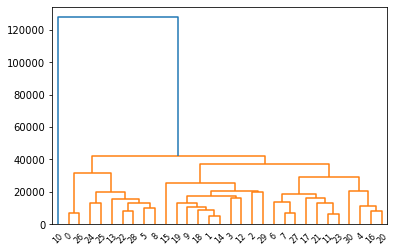

In [50]:
dendrogram(Z)

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [40.0, 40.0, 62.5, 62.5],
  [20.0, 20.0, 51.25, 51.25],
  [5.0, 5.0, 35.625, 35.625]],
 'dcoord': [[0.0, 31429.518413345966, 31429.518413345966, 0.0],
  [0.0, 25231.56431198168, 25231.56431198168, 0.0],
  [0.0, 20416.639358639415, 20416.639358639415, 0.0],
  [0.0, 29026.220246136607, 29026.220246136607, 20416.639358639415],
  [25231.56431198168,
   36879.10588336548,
   36879.10588336548,
   29026.220246136607],
  [31429.518413345966,
   41920.74869486125,
   41920.74869486125,
   36879.10588336548],
  [0.0, 127899.6883828269, 127899.6883828269, 41920.74869486125]],
 'ivl': ['10', '(2)', '(7)', '15', '(9)', '(7)', '30', '(3)'],
 'leaves': [10, 33, 51, 15, 53, 50, 30, 40],
 'color_list': ['C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C0']}

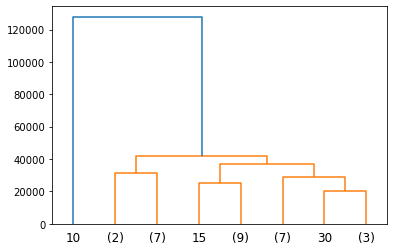

In [51]:
dendrogram(Z,truncate_mode='lastp',p=8)

### Done with spearman rank and correlation above .65

In [52]:
corr_arr_spearman = grand_zip_df.corrwith(grand_zip_df.CaseCountCumulative,method='spearman')
INDEXARRAYSPEARMAN = [corr_arr_spearman.index.get_loc(i) for i in ['CaseCount30','Population','CaseCount14','HouseholdsperZIPCode','MalePopulation','FemalePopulation','HispanicPopulation','WhitePopulation','Children','NumberofBusinesses']]
print(corr_arr_spearman)
print(corr_arr_spearman[INDEXARRAYSPEARMAN])

ZipCode                       0.227419
Latitude                      0.137903
Longitude                     0.089919
Elevation                     0.339383
HouseholdsperZIPCode          0.858065
AverageHouseValue             0.108468
AvgIncomePerHousehold         0.149597
PersonsPerHousehold           0.190274
WhitePopulation               0.680242
MedianAge                     0.143952
MalePopulation                0.794758
FemalePopulation              0.790726
BlackPopulation               0.453272
HispanicPopulation            0.783871
RetiredWorkers                0.745968
DisabledWorkers               0.631048
Spouses                       0.628692
Children                      0.672850
NumberofBusinesses            0.645161
#ofEmployees                  0.427823
Population                    0.905242
CaseCountCumulative           1.000000
CaseCount30                   0.897581
CaseCount14                   0.877739
CaseCountPer100KCumulative    0.355645
CaseCountPer100K30       

Metric function

This uses haversine formula

In [53]:
def custom_metric0(central_1, central_2, weight=1):
    lat1, lng1 = central_1[1:3]
    lat2, lng2 = central_2[1:3]
    lat1, lat2, lng1, lng2 = np.deg2rad(np.asarray([lat1, lat2, lng1, lng2]))

    dlat = lat2 - lat1
    dlng = lng2 - lng1
    
    h = (1 - np.cos(dlat))/2. + np.cos(lat1)*np.cos(lat2)*(1 - np.cos(dlng))/2.
    km = 2*6371*np.arcsin(np.sqrt(h)) #2 and 6371 are constants that should be there
    MW = np.abs(central_1[INDEXARRAYSPEARMAN] - central_2[INDEXARRAYSPEARMAN])
    return km + np.sum(np.multiply(MW,corr_arr_spearman[INDEXARRAYSPEARMAN]))

In [54]:
Z0 = linkage(grand_zip_df, method='average', metric=custom_metric0)

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [20.0, 20.0, 42.5, 42.5],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [70.0, 70.0, 90.0, 90.0],
  [31.25, 31.25, 80.0, 80.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [105.0, 105.0, 122.5, 122.5],
  [145.0, 145.0, 155.0, 155.0],
  [113.75, 113.75, 150.0, 150.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [185.0, 185.0, 202.5, 202.5],
  [175.0, 175.0, 193.75, 193.75],
  [225.0, 225.0, 235.0, 235.0],
  [184.375, 184.375, 230.0, 230.0],
  [165.0, 165.0, 207.1875, 207.1875],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [260.0, 260.0, 290.0, 290.0],
  [245.0, 245.0, 275.0, 275.0],
  [186.09375, 186.09375, 260.0, 260.0],
  [131.875, 131.875, 223.046875, 223.046875],
  [55.625, 55.625, 177.4609375, 177.4609375],
  [5.0, 5.0, 116.54296875, 116.54296875]],

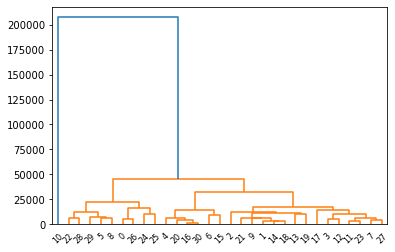

In [55]:
dendrogram(Z0)

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [60.0, 60.0, 82.5, 82.5],
  [30.0, 30.0, 71.25, 71.25],
  [5.0, 5.0, 50.625, 50.625]],
 'dcoord': [[0.0, 12389.090752142438, 12389.090752142438, 0.0],
  [0.0, 15851.319432708968, 15851.319432708968, 0.0],
  [12389.090752142438,
   22114.089373416617,
   22114.089373416617,
   15851.319432708968],
  [0.0, 14323.601139811264, 14323.601139811264, 0.0],
  [0.0, 13846.91617511173, 13846.91617511173, 0.0],
  [0.0, 16760.408626425848, 16760.408626425848, 13846.91617511173],
  [14323.601139811264,
   32251.373423158937,
   32251.373423158937,
   16760.408626425848],
  [22114.089373416617,
   45716.43971288556,
   45716.43971288556,
   32251.373423158937],
  [0.0, 207652.66588513815, 207652.66588513815, 45716.43971288556]],
 'ivl': ['10', '(2)', '(3)', '(2)', '(2)', '(4)', '(2)', '(8)', '17', '(6)'],
 'leaves': [10, 4

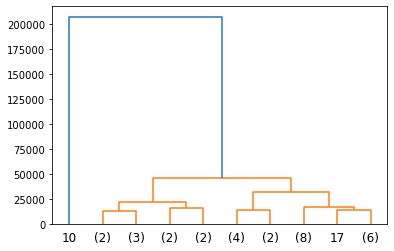

In [56]:
dendrogram(Z0,truncate_mode='lastp',p=10)

In [57]:
Z1 = linkage(grand_zip_df, method='weighted', metric=custom_metric0)

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [60.0, 60.0, 82.5, 82.5],
  [30.0, 30.0, 71.25, 71.25],
  [5.0, 5.0, 50.625, 50.625]],
 'dcoord': [[0.0, 12903.515483223051, 12903.515483223051, 0.0],
  [0.0, 14922.639647780345, 14922.639647780345, 0.0],
  [12903.515483223051,
   24069.82986053475,
   24069.82986053475,
   14922.639647780345],
  [0.0, 15851.319432708968, 15851.319432708968, 0.0],
  [0.0, 12711.013755013999, 12711.013755013999, 0.0],
  [0.0, 17524.295553255157, 17524.295553255157, 12711.013755013999],
  [15851.319432708968,
   29172.42349392979,
   29172.42349392979,
   17524.295553255157],
  [24069.82986053475,
   50991.553420706725,
   50991.553420706725,
   29172.42349392979],
  [0.0, 206882.33651283738, 206882.33651283738, 50991.553420706725]],
 'ivl': ['10', '(4)', '(2)', '17', '(6)', '(2)', '(2)', '(8)', '(2)', '(3)'],
 'leaves': [10, 4

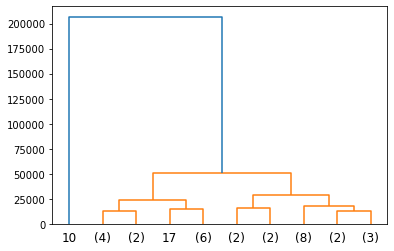

In [58]:
dendrogram(Z1,truncate_mode='lastp',p=10)

https://www.youtube.com/watch?v=JcfIeaGzF8A&ab_channel=TheEngineeringWorld

Lat,Long df generation

In [64]:
lat_long_df = sqldf("SELECT Latitude, Longitude from grand_zip_df;")

In [67]:
lat_long_df.head()

,Latitude,Longitude
0,40.106049,-82.898116
1,40.100474,-83.013908
2,39.995575,-82.999464
3,40.020272,-83.017128
4,39.971834,-82.966754


# Kmeans clustering

In [68]:
def tPlot(df):
    sns.set_style("darkgrid")
    sns.scatterplot(data=df,x="Longitude",y="Latitude",hue="yT",palette="dark:salmon_r")
    plt.scatter(x=[df[df.yT == i].Longitude.mean() for i in df.yT.unique()],y=[df[df.yT == i].Latitude.mean() for i in df.yT.unique()],marker = "x",color = "g")

Weight generation

In [59]:
def kmeansweighting(vect):
    return np.sum(np.multiply(vect,corr_arr_spearman[INDEXARRAYSPEARMAN]))

In [60]:
kmeanswts = grand_zip_df.apply(lambda x: kmeansweighting(x),axis=1)

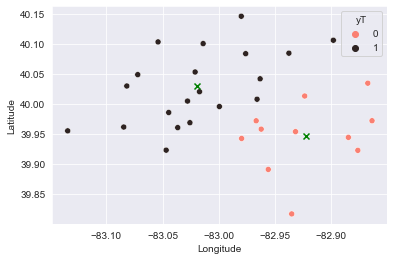

In [69]:
kmeans = KMeans(n_clusters=2)
kmeansfit = kmeans.fit(lat_long_df,kmeanswts)
y_kmeans = kmeans.predict(lat_long_df)
lat_long_dfktemp = lat_long_df.copy()
lat_long_dfktemp['yT'] = kmeansfit.labels_
tPlot(lat_long_dfktemp)

In [63]:
k = 2

Hclustering =AgglomerativeClustering(n_clusters = k, affinity = custom_metric0,linkage="average")
Hclustering.fit(grand_zip_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

***
#  NOT USED
***

### Run correlations np functions are:

- sin
- tan
- arcsin
- arctan
- exp
- log


In [76]:
INDEXARRAY = np.concatenate((np.arange(-5,-1),np.arange(2,len(corr_arr)-6)))
for i in np_funcs_arr:
    for j in np_funcs_arr:
        print(i,j)
        corr_arr = i(grand_zip_df[INDEXARRAY]).corrwith(j(grand_zip_df.CaseCountCumulative))
        print(corr_arr)

<ufunc 'sin'> <ufunc 'sin'>


KeyError: "None of [Int64Index([-5, -4, -3, -2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,\n            15, 16, 17, 18, 19, 20],\n           dtype='int64')] are in the [columns]"

In [ ]:
corr_arr = grand_zip_df.corrwith(grand_zip_df.CaseCountCumulative)
INDEXARRAY = np.concatenate((np.arange(-5,-1),np.arange(2,len(corr_arr)-6)))
print(corr_arr[INDEXARRAY])

In [82]:
#np_funcs_arr = [np.sin,np.tan,np.arcsin,np.arctan,np.exp,np.log]

[[-0.2794155 -0.2794155]
 [-0.2794155 -0.2794155]]


KeyError: "None of [Int64Index([-5, -4, -3, -2,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,\n            15, 16, 17, 18, 19, 20],\n           dtype='int64')] are in the [columns]"

In [37]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.columns = [re.sub("[() ]", "", col) for col in iris_df.columns]
print(sqldf("SELECT * FROM iris_df LIMIT 10;", locals()))
print(type(sqldf("SELECT * FROM zip_cases_df LIMIT 10;", locals())))
print(hp_df.dtypes)

   sepallengthcm  sepalwidthcm  petallengthcm  petalwidthcm species
0            5.1           3.5            1.4           0.2  setosa
1            4.9           3.0            1.4           0.2  setosa
2            4.7           3.2            1.3           0.2  setosa
3            4.6           3.1            1.5           0.2  setosa
4            5.0           3.6            1.4           0.2  setosa
5            5.4           3.9            1.7           0.4  setosa
6            4.6           3.4            1.4           0.3  setosa
7            5.0           3.4            1.5           0.2  setosa
8            4.4           2.9            1.4           0.2  setosa
9            4.9           3.1            1.5           0.1  setosa
<class 'pandas.core.frame.DataFrame'>
id             object
name           object
address        object
lat           float64
lng           float64
postalCode     object
cc             object
city           object
state          object
country        o

In [14]:
import requests
from bs4 import BeautifulSoup
import json
import re
#TODO figure out how to webscrape COVID-19 data from graph
r = requests.get(
    f"https://public.tableau.com/views/COVID-19OutbreakSummary_15918845768300/COVID19Summaryp3",
     params= {
        ":embed":"y",
        ":showAppBanner":"false",
        ":showShareOptions":"true",
        ":display_count":"no",
    }
)
print(r.url)
soup = BeautifulSoup(r.text, "html.parser")

tableauData = json.loads(soup.find("textarea",{"id": "tsConfigContainer"}).text)

dataUrl = f'https://public.tableau.com{tableauData["vizql_root"]}/bootstrapSession/sessions/{tableauData["sessionid"]}'
r = requests.post(dataUrl, data= {
    "sheet_id": tableauData["sheetId"],
})
dataReg = re.search('\d+;({.*})\d+;({.*})', r.text, re.MULTILINE)
info = json.loads(dataReg.group(1))
data = json.loads(dataReg.group(2))
#print(info)
print(data["secondaryInfo"]["presModelMap"]["dataDictionary"]["presModelHolder"]["genDataDictionaryPresModel"]["dataSegments"]["0"]["dataColumns"])
#<_sre.SRE_Match object; span=(0, 109884), match='72955;{"sheetName":"DASH: Patients v discharges",>

https://public.tableau.com/views/COVID-19OutbreakSummary_15918845768300/COVID19Summaryp3?:embed=y&:showAppBanner=false&:showShareOptions=true&:display_count=no&:showVizHome=no


KeyError: 'presModelMap'

# Awesome Selenium Webscraping Action

In [23]:
from selenium import webdriver 
import time
# import Action chains  
from selenium.webdriver.common.action_chains import ActionChains 
driver = webdriver.Firefox()

# Navigate to url
driver.get("https://public.tableau.com/views/COVID-19OutbreakSummary_15918845768300/COVID19Summaryp3?%3Adisplay_count=y&%3Aorigin=viz_share_link&%3AshowVizHome=no")

# Store 'google search' button web element
time.sleep(20)
mapfre = driver.find_element_by_xpath("//*[@id=\"tabZoneId106\"]/div/div/div/div")#//*[@id=\"view8239885986803340325_964909730081303188\"]/div[1]/div[2]")
#Set x and y offset positions of element
xOffset = 0 
yOffset = 0
ActionChains(driver).move_to_element(mapfre).perform()
ActionChains(driver).move_by_offset(xOffset,yOffset).perform()
time.sleep(12)
with open('temp_covid_zip.txt', 'w', encoding='utf-8') as f:
    f.write(str(driver.page_source))

In [10]:
#this script works for extracting zip and cases range
temp = ''
with open('temp_covid_zip.txt', 'r') as fin:
    temp = fin.read()
from bs4 import BeautifulSoup
soup = BeautifulSoup(temp, 'html.parser')
table = soup.find_all('div')[len(soup.find_all('div'))-3].table #grabs the table which stores the data
print(table.find_all('tr')[0].find_all('td')[2].string)
print(table.find_all('tr')[1].find_all('td')[2].string)

43224
868 - 1289


In [12]:
#Use for Y: -39 to start off with to go from 43211 to 43224
# Navigate to url
driver.get("https://public.tableau.com/views/COVID-19OutbreakSummary_15918845768300/COVID19Summaryp3?%3Adisplay_count=y&%3Aorigin=viz_share_link&%3AshowVizHome=no")

# Store 'google search' button web element
time.sleep(20)
mapfre = driver.find_element_by_xpath("//*[@id=\"tabZoneId106\"]/div/div/div/div")#//*[@id=\"view8239885986803340325_964909730081303188\"]/div[1]/div[2]")
#Set x and y offset positions of element
xOffset = 0 
yOffset = -39
ActionChains(driver).move_to_element(mapfre).perform()
ActionChains(driver).move_by_offset(xOffset,yOffset).perform()
time.sleep(12)
with open('temp_covid_zip.txt', 'w', encoding='utf-8') as f:
    f.write(str(driver.page_source))

InvalidSessionIdException: Message: Tried to run command without establishing a connection


In [9]:
#this script works for extracting zip and cases range
# -39 is a success
temp = ''
with open('temp_covid_zip.txt', 'r') as fin:
    temp = fin.read()
from bs4 import BeautifulSoup
soup = BeautifulSoup(temp, 'html.parser')
table = soup.find_all('div')[len(soup.find_all('div'))-3].table #grabs the table which stores the data
print(table.find_all('tr')[0].find_all('td')[2].string)
print(table.find_all('tr')[1].find_all('td')[2].string)

43224
868 - 1289


In [ ]:
# @TODO: Calculate Difference between 43211 and 43224 latitude and create a scale factor